In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import time
np.random.seed(21)

Using TensorFlow backend.


## Preprocess data

**Steps**
- Load data with datetime format
- Sort values by date since it is time series data
- Initial entries for 'Change %' and 'Vol.' are in object mode; converted to numbers

In [2]:
# load data with datetime index
coal_data = pd.read_csv('../data/COAL_data.csv', parse_dates=[0])

# sort by date
coal_data.sort_values('Date', inplace=True)

# reindex dataframe
coal_data.set_index(keys=['Date'], drop=True, inplace=True)
print('='*40)

# check for missing values
print(coal_data.isnull().sum())
print('='*40)

# convert 'Change %' column entries to numbers
coal_data['Change %'] = coal_data['Change %'].apply(lambda x:float(x.split('%')[0]))

def convert(row):
    '''Function for converting volume entries to numbers
    Input: row ---> Row entry; for ex: 5.1M, 8.22K
    Output num ---> Volume in numbers; for ex: 5.1M to 5100000  
    '''
    if row[-1] == 'M':
        num = float(row[:-1])*1000000
    else:
        num = float(row[:-1])*1000
    return num

# convert 'Vol.' column entries to numbers
coal_data['Vol.'] = coal_data['Vol.'].apply(lambda x:convert(x))

coal_data.head()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-07,319.90,351.00,355.7,317.9,44120000.0,-8.51
2010-11-14,331.95,322.00,339.3,309.3,23180000.0,3.77
2010-11-21,312.55,334.65,336.7,301.0,16770000.0,-5.84
2010-11-28,322.30,314.15,326.0,308.2,6860000.0,3.12
2010-12-05,316.70,320.00,324.9,307.5,5120000.0,-1.74


In [3]:
coal_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 417 entries, 2010-11-07 to 2018-10-28
Data columns (total 6 columns):
Price       417 non-null float64
Open        417 non-null float64
High        417 non-null float64
Low         417 non-null float64
Vol.        417 non-null float64
Change %    417 non-null float64
dtypes: float64(6)
memory usage: 22.8 KB


## Visualize trends

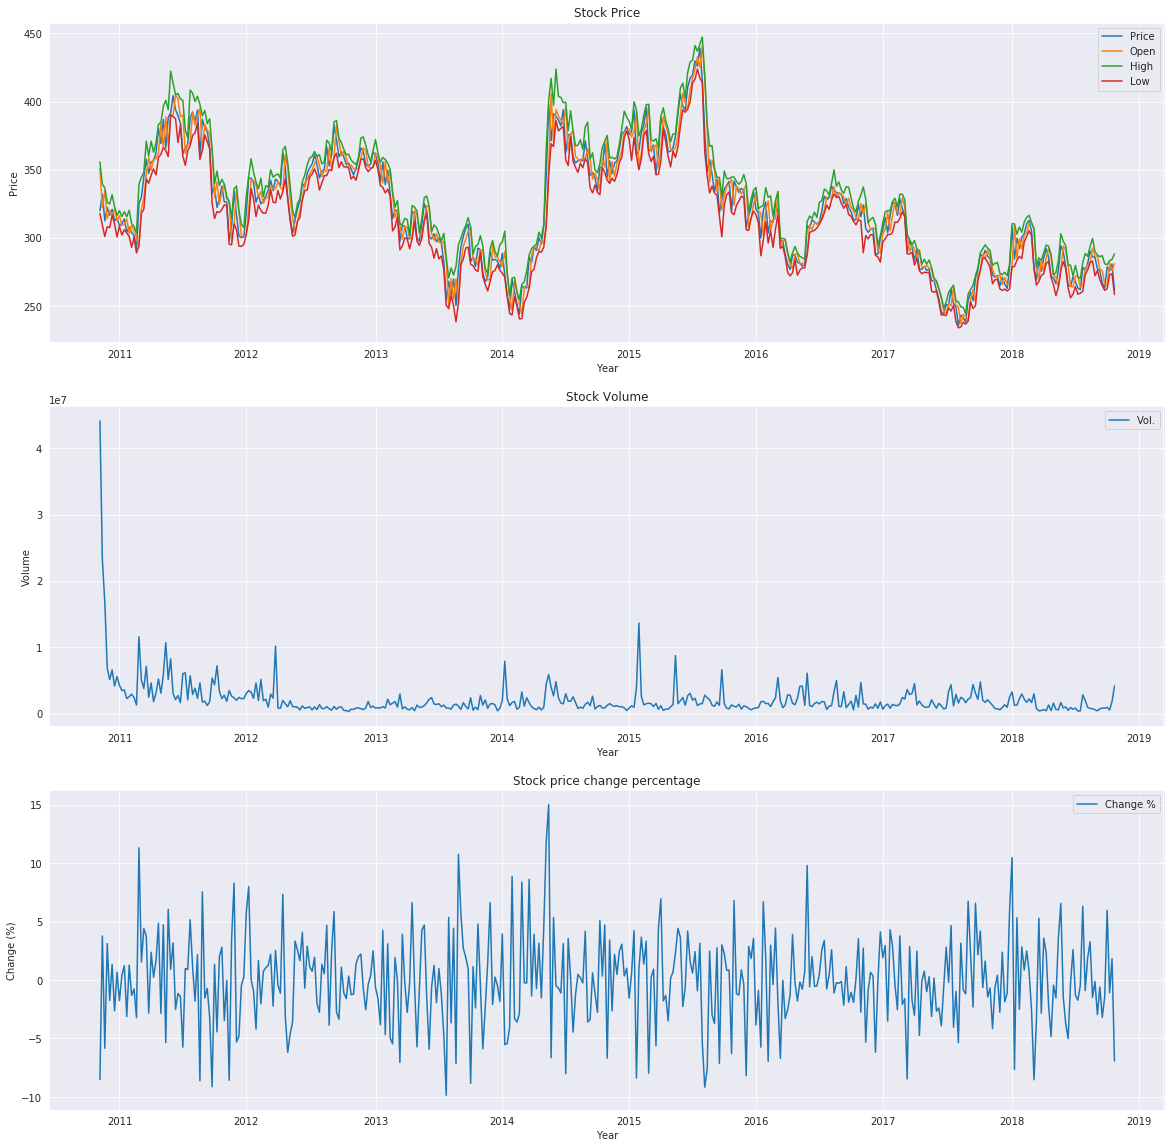

In [4]:
# initialize figure and axes
fig, (ax_1, ax_2, ax_3) = plt.subplots(3,1, figsize=(20,20))

# plot open, close, high and low prices
coal_data.plot(y=['Price', 'Open', 'High', 'Low'], ax=ax_1)
ax_1.set_title('Stock Price')
ax_1.set_xlabel('Year')
ax_1.set_ylabel('Price')

# plot volume
coal_data.plot(y='Vol.', ax=ax_2)
ax_2.set_title('Stock Volume')
ax_2.set_xlabel('Year')
ax_2.set_ylabel('Volume')

# plot percentage change
coal_data.plot(y='Change %', ax=ax_3)
ax_3.set_title('Stock price change percentage')
ax_3.set_xlabel('Year')
ax_3.set_ylabel('Change (%)')

plt.show()

## Normalize with window method and split into training and test

In [5]:
coal_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-07,319.90,351.00,355.7,317.9,44120000.0,-8.51
2010-11-14,331.95,322.00,339.3,309.3,23180000.0,3.77
2010-11-21,312.55,334.65,336.7,301.0,16770000.0,-5.84
2010-11-28,322.30,314.15,326.0,308.2,6860000.0,3.12
2010-12-05,316.70,320.00,324.9,307.5,5120000.0,-1.74


In [6]:
# split data
train_data = coal_data.iloc[:375,:]
test_data = coal_data.iloc[375:,:]

# normalize by splitting into window
window_size = 25
scaler = StandardScaler()

# normalize train data
for di in range(0, len(train_data), window_size):
    scaler.fit(train_data.iloc[di:di+window_size,:])
    train_data.iloc[di:di+window_size,:] = scaler.transform(train_data.iloc[di:di+window_size,:])

# normalize test data
test_data.iloc[:,:] = scaler.transform(test_data.iloc[:,:])

# split into train and test features and targets
X_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0]
X_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0]

In [7]:
X_train.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2010-11-07,1.257742,0.848901,0.111025,4.129395,-2.313590
2010-11-14,-0.168604,0.118702,-0.328171,1.787850,0.871630
2010-11-21,0.453578,0.002939,-0.752047,1.071073,-1.621038
2010-11-28,-0.554701,-0.473472,-0.384348,-0.037080,0.703031
2010-12-05,-0.266973,-0.522449,-0.420096,-0.231650,-0.557569


In [8]:
X_test.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2018-01-14,2.824275,2.250240,1.188704,-0.743392,-2.223597
2018-01-21,1.275936,1.789855,1.471612,-0.724288,1.229672
2018-01-28,2.201044,2.115194,1.643816,0.183170,-0.854518
2018-02-04,1.720637,1.875793,1.545414,0.890032,0.565071
2018-02-11,2.369836,2.342317,2.295734,0.154513,0.036048


In [9]:
y_train.head()

Date
2010-11-07   -0.279982
2010-11-14    0.263476
2010-11-21   -0.611469
2010-11-28   -0.171742
2010-12-05   -0.424303
Name: Price, dtype: float64

In [10]:
y_test.head()

Date
2018-01-14    0.962781
2018-01-21    1.809083
2018-01-28    1.391500
2018-02-04    1.853626
2018-02-11    1.995604
Name: Price, dtype: float64

## Model Building with LSTM using Keras

In [11]:
# initialize model with Keras
model = Sequential()

# add 3 LSTM layers with dropout
model.add(LSTM(input_dim=5, output_dim=10, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.25))

# add Dense layer with ReLU activation
model.add(Dense(10,kernel_initializer="uniform",activation='relu'))        

# add Dense layer with Linear activation
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# start time
start = time.time()

# compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# model compilation time
print ('compilation time : ', time.time() - start)

compilation time :  0.049205780029296875


In [12]:
# Fit model on training data with validation data 5% of training data and 150 epochs
model.fit(X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]),y_train, nb_epoch=150, validation_split=0.05, batch_size=10)

Train on 356 samples, validate on 19 samples
Epoch 1/150
356/356 [==============================] - 3s 9ms/step - loss: 1.0147 - mean_squared_error: 1.0147 - val_loss: 0.7276 - val_mean_squared_error: 0.7276
Epoch 2/150
356/356 [==============================] - 0s 577us/step - loss: 1.0124 - mean_squared_error: 1.0124 - val_loss: 0.7304 - val_mean_squared_error: 0.7304
Epoch 3/150
356/356 [==============================] - 0s 602us/step - loss: 0.9876 - mean_squared_error: 0.9876 - val_loss: 0.7085 - val_mean_squared_error: 0.7085
Epoch 4/150
356/356 [==============================] - 0s 582us/step - loss: 0.8383 - mean_squared_error: 0.8383 - val_loss: 0.6237 - val_mean_squared_error: 0.6237
Epoch 5/150
356/356 [==============================] - 0s 594us/step - loss: 0.5049 - mean_squared_error: 0.5049 - val_loss: 0.5059 - val_mean_squared_error: 0.5059
Epoch 6/150
356/356 [==============================] - 0s 594us/step - loss: 0.3456 - mean_squared_error: 0.3456 - val_loss: 0.3435 

356/356 [==============================] - 0s 601us/step - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 51/150
356/356 [==============================] - 0s 572us/step - loss: 0.0840 - mean_squared_error: 0.0840 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 52/150
356/356 [==============================] - 0s 587us/step - loss: 0.0970 - mean_squared_error: 0.0970 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 53/150
356/356 [==============================] - 0s 564us/step - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 54/150
356/356 [==============================] - 0s 586us/step - loss: 0.0781 - mean_squared_error: 0.0781 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 55/150
356/356 [==============================] - 0s 584us/step - loss: 0.0851 - mean_squared_error: 0.0851 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 56/150
356/

356/356 [==============================] - 0s 658us/step - loss: 0.0859 - mean_squared_error: 0.0859 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 100/150
356/356 [==============================] - 0s 575us/step - loss: 0.0754 - mean_squared_error: 0.0754 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 101/150
356/356 [==============================] - 0s 576us/step - loss: 0.0818 - mean_squared_error: 0.0818 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 102/150
356/356 [==============================] - 0s 606us/step - loss: 0.0790 - mean_squared_error: 0.0790 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 103/150
356/356 [==============================] - 0s 592us/step - loss: 0.0854 - mean_squared_error: 0.0854 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 104/150
356/356 [==============================] - 0s 605us/step - loss: 0.0816 - mean_squared_error: 0.0816 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 105/15

356/356 [==============================] - 0s 593us/step - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 149/150
356/356 [==============================] - 0s 597us/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 150/150
356/356 [==============================] - 0s 731us/step - loss: 0.0751 - mean_squared_error: 0.0751 - val_loss: 0.0206 - val_mean_squared_error: 0.0206


## Making predictions with LSTM

In [13]:
# make predictions
y_pred = model.predict(X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1]))

# create copy of original test data to rescale data into original format
test_predictions = test_data.copy()

# set 'Price' feature value as predicted values
test_predictions[['Price']] = y_pred

# inverse transform predictions data
test_predictions.iloc[:,:] = scaler.inverse_transform(test_predictions)
preds = test_predictions.iloc[:,0]

# inverse transform original test data
test_data.iloc[:,:] = scaler.inverse_transform(test_data)
actual = test_data.iloc[:,0]

In [14]:
print(preds)

Date
2018-01-14    284.265637
2018-01-21    298.426962
2018-01-28    291.624398
2018-02-04    295.771584
2018-02-11    298.848089
2018-02-18    301.375170
2018-02-25    300.953899
2018-03-04    297.224501
2018-03-11    278.818074
2018-03-18    267.874216
2018-03-25    286.784351
2018-04-01    275.670804
2018-04-08    287.831820
2018-04-15    292.208885
2018-04-22    286.200338
2018-04-29    273.123694
2018-05-06    270.422032
2018-05-13    262.933445
2018-05-20    277.719447
2018-05-27    296.795540
2018-06-03    289.210998
2018-06-10    281.534101
2018-06-17    263.847703
2018-06-24    264.140864
2018-07-01    269.659240
2018-07-08    269.448466
2018-07-15    262.520761
2018-07-22    262.072511
2018-07-29    280.520598
2018-08-05    278.301673
2018-08-12    285.854643
2018-08-19    292.153993
2018-08-26    289.449370
2018-09-02    285.125106
2018-09-09    279.117796
2018-09-16    277.229297
2018-09-23    269.418834
2018-09-30    265.563490
2018-10-07    281.907915
2018-10-14    278.65

In [15]:
print(actual)

Date
2018-01-14    284.45
2018-01-21    299.65
2018-01-28    292.15
2018-02-04    300.45
2018-02-11    303.00
2018-02-18    310.55
2018-02-25    312.80
2018-03-04    304.70
2018-03-11    278.70
2018-03-18    269.25
2018-03-25    283.50
2018-04-01    275.45
2018-04-08    285.35
2018-04-15    292.05
2018-04-22    285.55
2018-04-29    271.75
2018-05-06    270.55
2018-05-13    266.40
2018-05-20    276.05
2018-05-27    294.15
2018-06-03    289.90
2018-06-10    279.05
2018-06-17    265.10
2018-06-24    264.40
2018-07-01    271.30
2018-07-08    267.75
2018-07-15    263.15
2018-07-22    261.95
2018-07-29    278.50
2018-08-05    276.00
2018-08-12    281.20
2018-08-19    290.40
2018-08-26    286.10
2018-09-02    285.75
2018-09-09    277.30
2018-09-16    275.65
2018-09-23    266.85
2018-09-30    263.05
2018-10-07    278.75
2018-10-14    275.75
2018-10-21    280.80
2018-10-28    261.35
Name: Price, dtype: float64


## Calculating Mean-Squared-Error on test data

In [16]:
# calculate mean squared error on test data
error = np.sqrt(mean_squared_error(preds, actual))
print(error)

3.329331616210026


## Comparing original and predicted prices

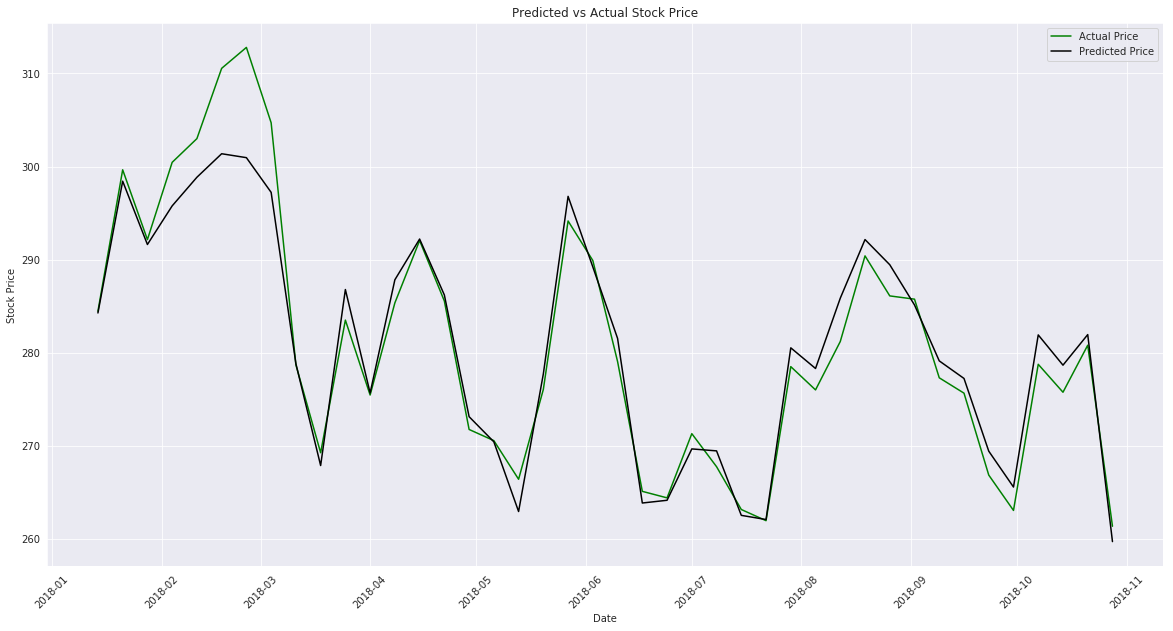

In [17]:
# comapre original vs predicted stock prices
plt.figure(figsize=(20,10))
plt.plot(actual, color='green')
plt.plot(preds, color='black')
plt.legend(['Actual Price', 'Predicted Price'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted vs Actual Stock Price')
plt.show()